In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sms-spam-collection-dataset' dataset.
Path to dataset files: /kaggle/input/sms-spam-collection-dataset


In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv(path + "/spam.csv", encoding="latin-1")
df.head()
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.head()

#check for class imbalance
df['v1'].value_counts()
df['v1'] = df['v1'].map({'ham': 0, 'spam': 1})
texts = df['v2'].tolist()
labels = df['v1'].tolist()


"\n#slight oversampling for spam\nfrom sklearn.utils import resample\ndf_majority = df[df['v1']=='ham']\ndf_minority = df[df['v1']=='spam']\n\n#class balancing\ndf_minority_upsampled = resample(df_minority, \n                                 replace=True,\n                                 n_samples=len(df_majority),\n                                 random_state=123)\n\ndf_upsampled = pd.concat([df_majority, df_minority_upsampled])\ndf_upsampled['v1'].value_counts()\n"

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# finetuning distillbert

model = "distilbert-base-uncased"
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
model = AutoModelForSequenceClassification.from_pretrained(model, num_labels=2)


from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)

train_dataset = SMSDataset(train_encodings, train_labels)
val_dataset = SMSDataset(val_encodings, val_labels)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import torch

class SMSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = SMSDataset(encodings, labels)


In [14]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    #evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [13]:
trainer.train()

Step,Training Loss
10,0.415600
20,0.124600
30,0.074400
40,0.136600
50,0.050900
60,0.084900
70,0.039600
80,0.037000
90,0.036900
100,0.051400


TrainOutput(global_step=837, training_loss=0.032562883304857085, metrics={'train_runtime': 163.6812, 'train_samples_per_second': 81.689, 'train_steps_per_second': 5.114, 'total_flos': 221402698428672.0, 'train_loss': 0.032562883304857085, 'epoch': 3.0})

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def get_preds(model, tokenizer, texts, batch_size=32):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            enc = tokenizer(batch_texts, truncation=True, padding=True, max_length=64, return_tensors="pt")
            enc = {key: val.to(device) for key, val in enc.items()}
            logits = model(**enc).logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

val_preds = get_preds(model, tokenizer, val_texts)


Accuracy: 0.9937
Precision: 0.9863
Recall: 0.9664
F1 Score: 0.9763


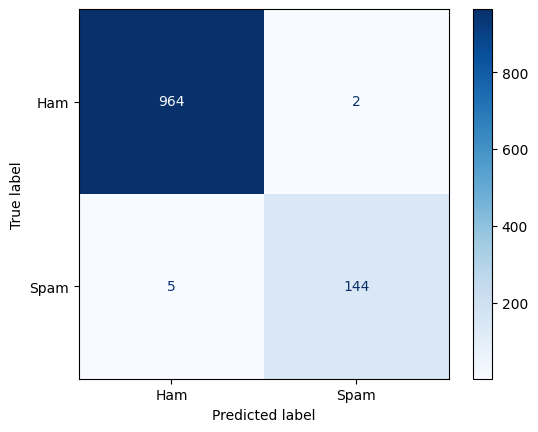

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
recall = recall_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.show()
